<a href="https://colab.research.google.com/github/AnandaIlyasa/bangkit-capstone-bahanbaku/blob/using-34-local-food-daatset/notebooks/food_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import models
from tensorflow.keras.applications.efficientnet import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

Download additional Indonesian food dataset from kaggle

In [9]:
! pip -q install kaggle

In [10]:
! mkdir ~/.kaggle

Required to upload kaggle.json file first to current directory (/content)
-- kaggle.json file contains api token and can be downloaded from kaggle acount page

In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

Download indonesian-food dataset from kaggle and extract

In [13]:
! kaggle datasets download -d arizbw/traditional-food-knowledge-of-indonesia

100% 3.10G/3.10G [00:31<00:00, 101MB/s]
100% 3.10G/3.10G [00:31<00:00, 107MB/s]


In [14]:
! unzip -q /content/traditional-food-knowledge-of-indonesia.zip

Check how many data images are there

In [15]:
print(len(os.listdir('/content/food-tfk-images')))

1645


Check what is data in csv file look like

In [16]:
with open('/content/dev.csv', 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    print(len(paths))
    print(paths[1].split(',')[:3])

165
['IMG_8882.jpg', '1', 'gulai-ikan-mas']


Preparing data -- split images to train and test folder based on train.csv, dev.csv, and test.csv file

In [51]:
def prepare_data(filepath, src, dest):
  image_classes = defaultdict(list)
  with open(filepath, 'r') as csv:
      csv.readline()
      lines = [read.strip() for read in csv.readlines()]
      for line in lines:
        file_desc = line.split(',')[:3]
        image_classes[file_desc[2]].append(file_desc[0])

  if not os.path.exists(dest):
    os.makedirs(dest)

  for food in image_classes.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in image_classes[food]:
      copy(os.path.join(src,i), os.path.join(dest,food,i))
  print("Copying Done!")
  # return image_classes

In [ ]:
! rm -R ./dataset

In [52]:
print("Creating train data...")
prepare_data('/content/train.csv', '/content/food-tfk-images', '/content/dataset')
prepare_data('/content/dev.csv', '/content/food-tfk-images', '/content/dataset')
prepare_data('/content/test.csv', '/content/food-tfk-images', '/content/dataset')

Creating train data...
Copying Done!
Copying Done!
Copying Done!


In [54]:
!find ./dataset -type f | wc -l

1643


Get food classes from train folder

In [55]:
food_classes = sorted(os.listdir('./dataset'))

Preparing Data (Transform and Load data from directory)

In [56]:
# n_classes,num_epochs, nb_train_samples,nb_validation_samples = 25, 2, train_files, test_files
def prepare_data_input_pipeline():
  K.clear_session()

  img_width, img_height = 150, 150
  data_dir = './dataset'

  datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      validation_split=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  train_generator = datagen.flow_from_directory(
      data_dir,
      target_size=(img_height, img_width),
      batch_size=30,
      subset='training',
      class_mode='categorical')

  validation_generator = datagen.flow_from_directory(
      data_dir,
      target_size=(img_height, img_width),
      batch_size=10,
      subset='validation',
      class_mode='categorical')
  
  return train_generator, validation_generator

Load pre-trained model, take some layers from it, and define additional layer on top of it

In [57]:
# for layer in inception.layers:
#   layer.trainable = False
# last_layer = inception.get_layer('mixed7')
# last_output = last_layer.output
def prepare_model(n_classes):
  # bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'

  efficient_net = EfficientNetB7(weights='imagenet', include_top=False, classes=n_classes)
  for layer in efficient_net.layers:
    layer.trainable = False
  last_layer = efficient_net.get_layer('block6a_project_conv')
  last_output = last_layer.output

  x = last_output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)               
  x = Dense(n_classes, activation='softmax')(x) 
  model = Model(efficient_net.input, x)

  optimizer = Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

Mount google drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train the model and create checkpoint to continue the training later

In [ ]:
n_classes = 34 #34

train_generator, validation_generator = prepare_data_input_pipeline()

model = prepare_model(n_classes)

checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Google_Bangkit/capstone/checkpoint_'+str(n_classes)+'_classes_traiditional', save_best_only=True)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint])

# model.save_weights('weights')
# class_map = train_generator.class_indices

Found 1329 images belonging to 34 classes.
Found 314 images belonging to 34 classes.
Epoch 1/10
45/45 [==============================] - 289s 6s/step - loss: 0.9014 - accuracy: 0.8292 - val_loss: 0.0815 - val_accuracy: 0.9841
Epoch 2/10
45/45 [==============================] - 263s 6s/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 253s 6s/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 258s 6s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 253s 6s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 252s 6s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 7/10
29/45 [==================>...........] - ETA: 44s - loss: 

Continue training from the checkpoint

In [ ]:
# continue training
n_classes=34
train_generator, validation_generator = prepare_data_input_pipeline()
checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Google_Bangkit/capstone/checkpoint_'+str(n_classes)+'_classes_traiditional', save_best_only=True)
loaded_model = load_model('/content/drive/MyDrive/Google_Bangkit/capstone/checkpoint_'+str(n_classes)+'_classes_traiditional') # checkpoint folder from gdrive
new_history = loaded_model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint])

Found 23176 images belonging to 25 classes.
Found 901 images belonging to 25 classes.
Epoch 1/10
773/773 [==============================] - 247s 299ms/step - loss: 1.6764 - accuracy: 0.5010 - val_loss: 1.8433 - val_accuracy: 0.4395
Epoch 2/10
773/773 [==============================] - 228s 295ms/step - loss: 1.6670 - accuracy: 0.4969 - val_loss: 1.8162 - val_accuracy: 0.4495
Epoch 3/10
773/773 [==============================] - 197s 255ms/step - loss: 1.6548 - accuracy: 0.5072 - val_loss: 1.8653 - val_accuracy: 0.4229
Epoch 4/10
773/773 [==============================] - 197s 255ms/step - loss: 1.6600 - accuracy: 0.5050 - val_loss: 1.8602 - val_accuracy: 0.4284
Epoch 5/10
773/773 [==============================] - 221s 286ms/step - loss: 1.6541 - accuracy: 0.5046 - val_loss: 1.8052 - val_accuracy: 0.4573
Epoch 6/10
773/773 [==============================] - 198s 256ms/step - loss: 1.6514 - accuracy: 0.5064 - val_loss: 1.8102 - val_accuracy: 0.4395
Epoch 7/10
773/773 [==================

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/25_classes')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/25_classes/assets


In [ ]:
!cp -r $(pwd)/checkpoint_25 /content/drive/MyDrive/Colab\ Notebooks

# Visualize the accuracy and loss plots

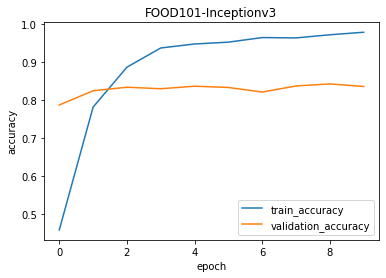

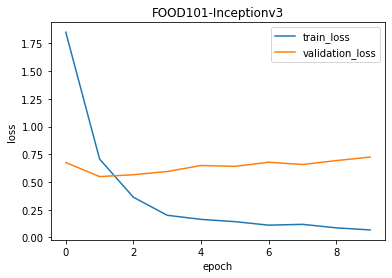

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')